In [29]:
import matplotlib
%matplotlib nbagg

import os
import intan
import imp
imp.reload(intan)
import plot
import functions
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Plot continuous recording

In [44]:
## Cell 1
# filename = "/Volumes/NO NAME/ephys__180615_211751/ephys__A_180615_211751.clp" # Flashes in V1
# filename = "/Volumes/NO NAME/ephys__180615_212356/ephys__A_180615_212356.clp" # Puffs in V1

## Cell 2
# filename = "/Volumes/NO NAME/ephys__180615_215314/ephys__A_180615_215314.clp" # Flashes in V1
# filename = "/Volumes/NO NAME/ephys__180615_215556/ephys__A_180615_215556.clp" # Puffs in V1

## Cell 3
# filename = "/Volumes/NO NAME/ephys__180615_221426/ephys__A_180615_221426.clp" # Flashes in V1
filename = "/Users/cs/data/ION19/ephys__190615_173031/ephys__A_190615_173031.clp"
# filename = "/Users/cs/data/ION19/ephys__190615_173311/ephys__A_190615_173311.clp"
# filename = "/Users/cs/data/ION19/ephys__190615_173724/ephys__A_190615_173724.clp"

data = intan.IntanFile(filename)
data_aux = intan.IntanFile(filename.replace("_A_", "_AUX_"))

In [45]:
print(data.data.keys(), data_aux.data.keys())
data_aux.data['DigitalOut'].shape
data.data['Measured'].shape

(['Clamp', 'TotalClamp', 'Measured', 'Time'], ['DigitalOut', 'DigitalOutAll', 'DigitalIn', 'DigitalInAll', 'ADC', 'Time'])


(7569279,)

<IPython.core.display.Javascript object>


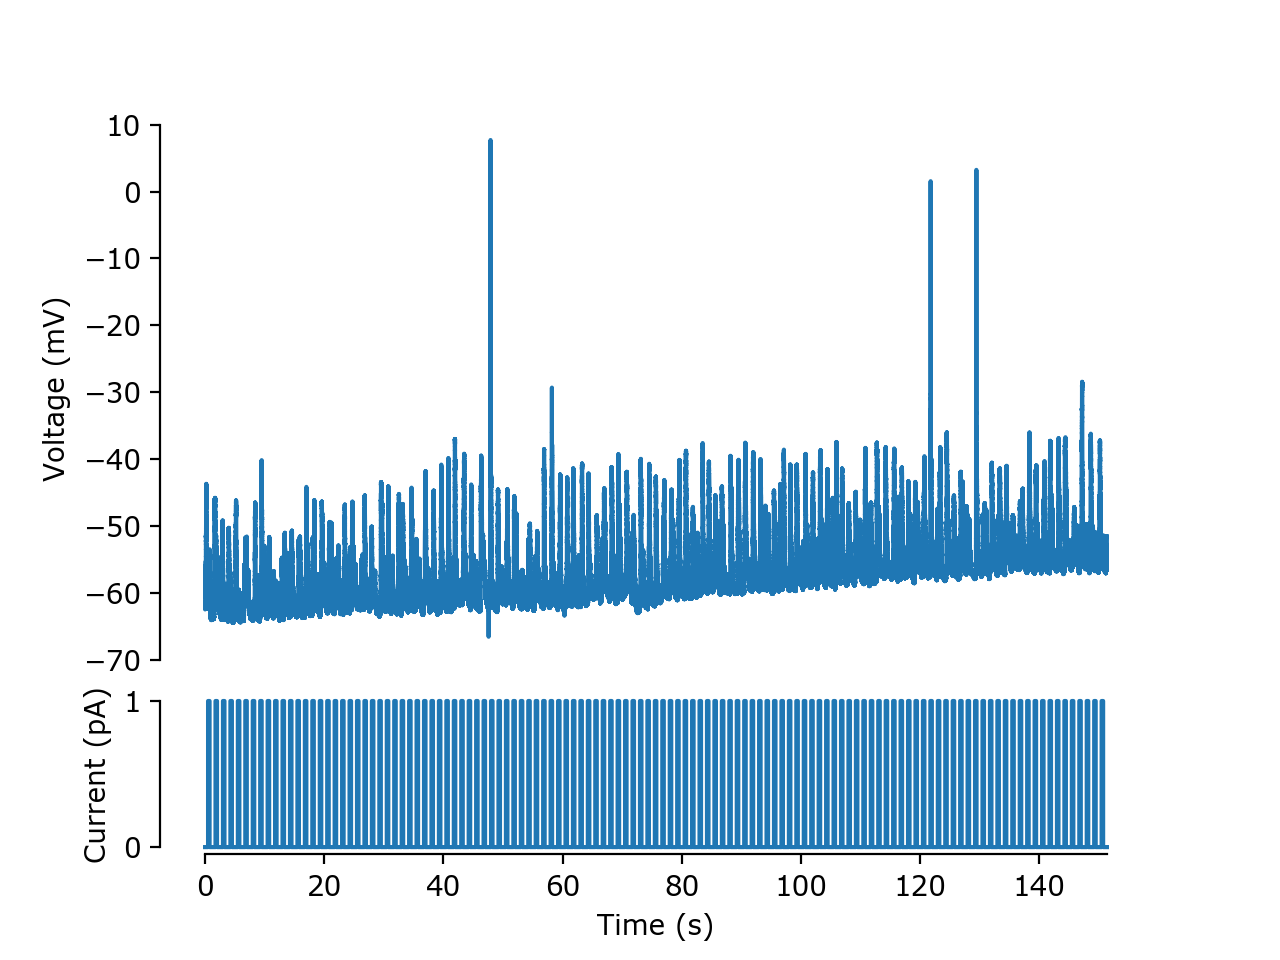

puffs


In [46]:
fig, axv, axi = plot.plot_traces(mode='cclamp', xlabel='Time (s)')

starttime = 0
times = data.data['Time']
if np.sum(np.diff(data_aux.data['DigitalOutAll'][0]) > 0.5) > np.sum(
    np.diff(data_aux.data['DigitalOutAll'][1]) > 0.5):
    pulse = data_aux.data['DigitalOutAll'][0][times > starttime]
    stimtype = "puffs"
else:
    pulse = data_aux.data['DigitalOutAll'][1][times > starttime]
    stimtype = "flashes"
print(stimtype)
sweep = data.data['Measured'][times > starttime] * 1e3
times = data.data['Time'][times > starttime]

axv.plot(times, sweep)
axi.plot(times, pulse)
plt.savefig(filename.replace("clp", "png"))

<IPython.core.display.Javascript object>


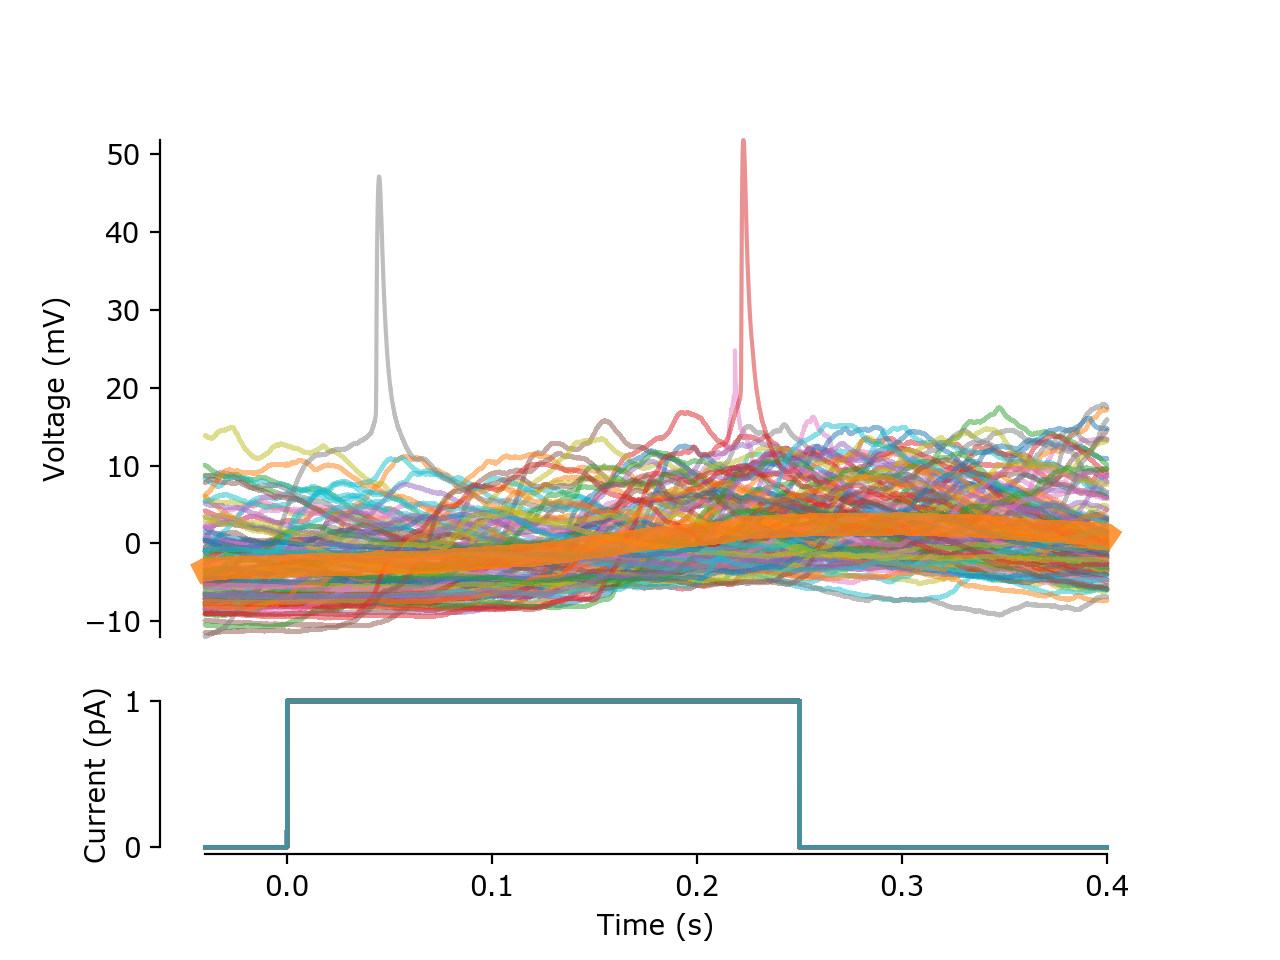

121


In [49]:
fig, axv, axi = plot.plot_traces(mode='cclamp', xlabel='Time (s)')

pulse -= pulse.min()
ipulse = np.where(np.diff((pulse > 0.5*pulse.max()).astype(np.float)) == 1)[0]
nsamples_post = 20000
nsamples_pre = 2000
sweeps = []
for ip in ipulse:
    if len(times[ip-nsamples_pre:ip+nsamples_post]) != len(sweep[ip-nsamples_pre:ip+nsamples_post]):
        continue
    if len(sweeps) > 0 and len(sweep[ip-nsamples_pre:ip+nsamples_post]) != len(sweeps[-1]):
        continue
    sweep_corr = sweep[ip-nsamples_pre:ip+nsamples_post]-sweep[ip-nsamples_pre:ip+nsamples_post].mean()
    axv.plot(
        times[ip-nsamples_pre:ip+nsamples_post]-times[ip],
        sweep_corr, alpha=0.5)

    sweeps.append(sweep_corr)
        
    axi.plot(
        times[ip-nsamples_pre:ip+nsamples_post]-times[ip],
        pulse[ip-nsamples_pre:ip+nsamples_post], alpha=0.5)
print(len(sweeps))
axv.plot(
    times[ipulse[0]-nsamples_pre:ipulse[0]+nsamples_post]-times[ipulse[0]],
    np.mean(sweeps, axis=0), alpha=0.8, lw=8)
plt.savefig(filename.replace(".clp", "_sta.png"))

# Frequency-current relationship (f-I)

In [8]:
data = intan.IntanFile("/Volumes/NO NAME/2017-06-17/whisky__170617_160553/whisky__A_170617_160553.clp")
data_aux = intan.IntanFile("/Volumes/NO NAME/2017-06-17/whisky__170617_160553/whisky__AUX_170617_160553.clp")
segments = data.header['Settings']['Waveform']['Segments']
seg_limits = np.array([(seg['Start'], seg['End']) for seg in segments])[1:-1]

In [26]:
pulsedelay = 25.0
pulsedur = 500.0
threshold = -15.0
rseries = 140.0

<IPython.core.display.Javascript object>


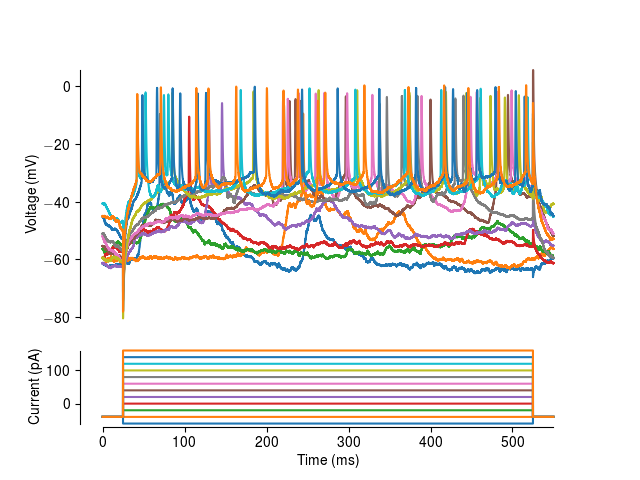

<IPython.core.display.Javascript object>


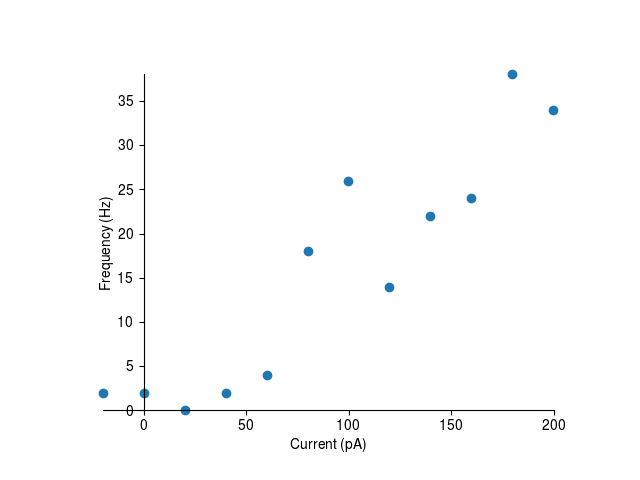

In [27]:
fig, axv, axi = plot.plot_traces(mode='cclamp')

pulses = []
fs = []
steady = []
dt = 1.0e3/data.header['Settings']['SamplingRate']
for seg_start, seg_end in zip(seg_limits[::3], seg_limits[2::3]):
    seg = (seg_start[0], seg_end[1])                    
    command = data.data['Clamp'][seg[0]:seg[1]]*1e12
    pulsebase = np.mean(command[:int(pulsedelay/dt)])
    pulsemax = np.max(command-pulsebase)
    pulsemin = np.min(command-pulsebase)
    if np.abs(pulsemax) > np.abs(pulsemin):
        pulseamp = pulsemax
    else:
        pulseamp = pulsemin
    pulses.append(pulseamp)
    corr = command*rseries*1e-3
    
    sweep = data.data['Measured'][seg[0]:seg[1]]*1e3-corr
    crossings = np.where(np.diff((sweep > threshold).astype(np.float)) == 1.0)[0]
    times = np.arange(sweep.shape[0])*dt
    fs.append(1e3*len(crossings)/pulsedur)
    axv.plot(times, sweep)
    axi.plot(times, command)

fig, ax = plot.plot_fi()
ax.plot(pulses, fs, 'o')
# ax.plot(pulses, steady)
plt.show()

In [29]:
settings = data.header['Settings']

In [30]:
settings['Waveform']

{'Interval': 0.0,
 'Segments': [{'AppliedValue': -1e-11,
   'End': 2500,
   'Start': 1,
   'TOffset': 1,
   'WaveformNumber': 0},
  {'AppliedValue': -1e-11,
   'End': 5000,
   'Start': 2501,
   'TOffset': 1,
   'WaveformNumber': 1},
  {'AppliedValue': -5.9999998e-11,
   'End': 30000,
   'Start': 5001,
   'TOffset': 1,
   'WaveformNumber': 1},
  {'AppliedValue': -1e-11,
   'End': 32500,
   'Start': 30001,
   'TOffset': 1,
   'WaveformNumber': 1},
  {'AppliedValue': -1e-11,
   'End': 35000,
   'Start': 32501,
   'TOffset': 30001,
   'WaveformNumber': 2},
  {'AppliedValue': -1e-11,
   'End': 60000,
   'Start': 35001,
   'TOffset': 30001,
   'WaveformNumber': 2},
  {'AppliedValue': -1e-11,
   'End': 62500,
   'Start': 60001,
   'TOffset': 30001,
   'WaveformNumber': 2},
  {'AppliedValue': -1e-11,
   'End': 65000,
   'Start': 62501,
   'TOffset': 60001,
   'WaveformNumber': 3},
  {'AppliedValue': 4e-11,
   'End': 90000,
   'Start': 65001,
   'TOffset': 60001,
   'WaveformNumber': 3},
  {'Ap

In [40]:
seg_limits[1:-1, 1]-seg_limits[1:-1, 0]

array([ 2499, 24999,  2499,  2499, 24999,  2499,  2499, 24999,  2499,
        2499, 24999,  2499,  2499, 24999,  2499,  2499, 24999,  2499,
        2499, 24999,  2499,  2499, 24999,  2499,  2499, 24999,  2499,
        2499, 24999,  2499])

In [60]:
data.data['Measured']

array([-0.04361084, -0.03584923, -0.03439694, ..., -0.03096494,
       -0.03099721, -0.03094472], dtype=float32)